In [9]:
import numpy as np
from scipy.io import loadmat
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


train_data = loadmat('./train_32x32.mat')


# Print the keys of the loaded data
print("Keys in train_data:", train_data.keys())
print("Shape of X_train:", train_data['X'].shape)
print("Shape of y_train:", train_data['y'].shape)
# Print the first five samples
# for i in range(1):
#     print(f"Sample {i + 1} - Shape: {X_train[:, :, :, i].shape}")
#     print(X_train[:, :, :, i])
#     print("Label:", y_train[i])
#     print("\n")

Keys in train_data: dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])
Shape of X_train: (32, 32, 3, 73257)
Shape of y_train: (73257, 1)


In [10]:
# Check for null values in each element
for key, value in train_data.items():
    if isinstance(value, np.ndarray) and value.size == 0:
        print(f"Null values in {key}")
    else: print(f"NO NULL in {key}")

NO NULL in __header__
NO NULL in __version__
NO NULL in __globals__
NO NULL in X
NO NULL in y


In [11]:
# Check the data types of each element
for key, value in train_data.items():
    print(f"Data type of {key}: {type(value)}")

Data type of __header__: <class 'bytes'>
Data type of __version__: <class 'str'>
Data type of __globals__: <class 'list'>
Data type of X: <class 'numpy.ndarray'>
Data type of y: <class 'numpy.ndarray'>


In [12]:
#data Extration (features)
X_train = train_data['X']
y_train = train_data['y']
classes = len(np.unique(y_train))
# print(classes)

# Create an empty list to store indices for each class
subset_classes = []

# Iterate over each class
for class_label in range(classes):
    # print(class_label)
    # Find indices of samples belonging to the current class
    indices_for_class = np.where(y_train == class_label+1)[0]
    
    # Check if there are enough samples for the current class
    if len(indices_for_class) >= 2500:
        # Randomly select 2500 samples if available
        selected_indices = np.random.choice(indices_for_class, size=2500, replace=False)
        subset_classes.extend(selected_indices)
    else:
        # If there are not enough samples, use all available samples for this class
        subset_classes.extend(indices_for_class)

# Convert the list to a NumPy array
subset_classes = np.array(subset_classes)
print(subset_classes)

# New dataset of size 2500
subset_classes_X_train = X_train[:, :, :, subset_classes ]
subset_classes_Y_train = y_train[subset_classes ]

# dataset verification
print("Shape of X_train_subset:", subset_classes_X_train.shape)
print("Shape of y_train_subset:", subset_classes_Y_train.shape)

[33097 20752 46713 ... 24943 27421 61370]
Shape of X_train_subset: (32, 32, 3, 25000)
Shape of y_train_subset: (25000, 1)


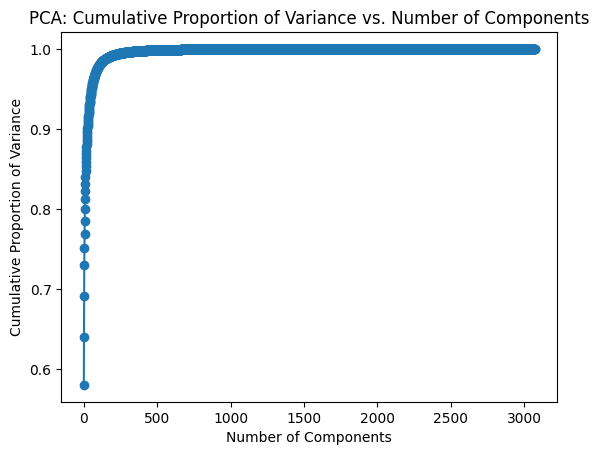

Number of components to keep 90% variance: 26


In [13]:
# Flatten the data for PCA
X_train_2D = subset_classes_X_train.reshape((32*32*3,-1))

# Standardize the data
scaler = StandardScaler()
X_train_standardized = X_train_2D.T

# Perform PCA
pca = PCA()
X_train_pca = pca.fit_transform(X_train_standardized)

# Cumulative sum of explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Find the number of components to keep for 90% variance
num_components_90 = np.argmax(cumulative_variance > 0.9) + 1

# Plot PoV against the number of components
plt.plot(cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Proportion of Variance')
plt.title('PCA: Cumulative Proportion of Variance vs. Number of Components')
plt.show()

print(f"Number of components to keep 90% variance: {num_components_90}")

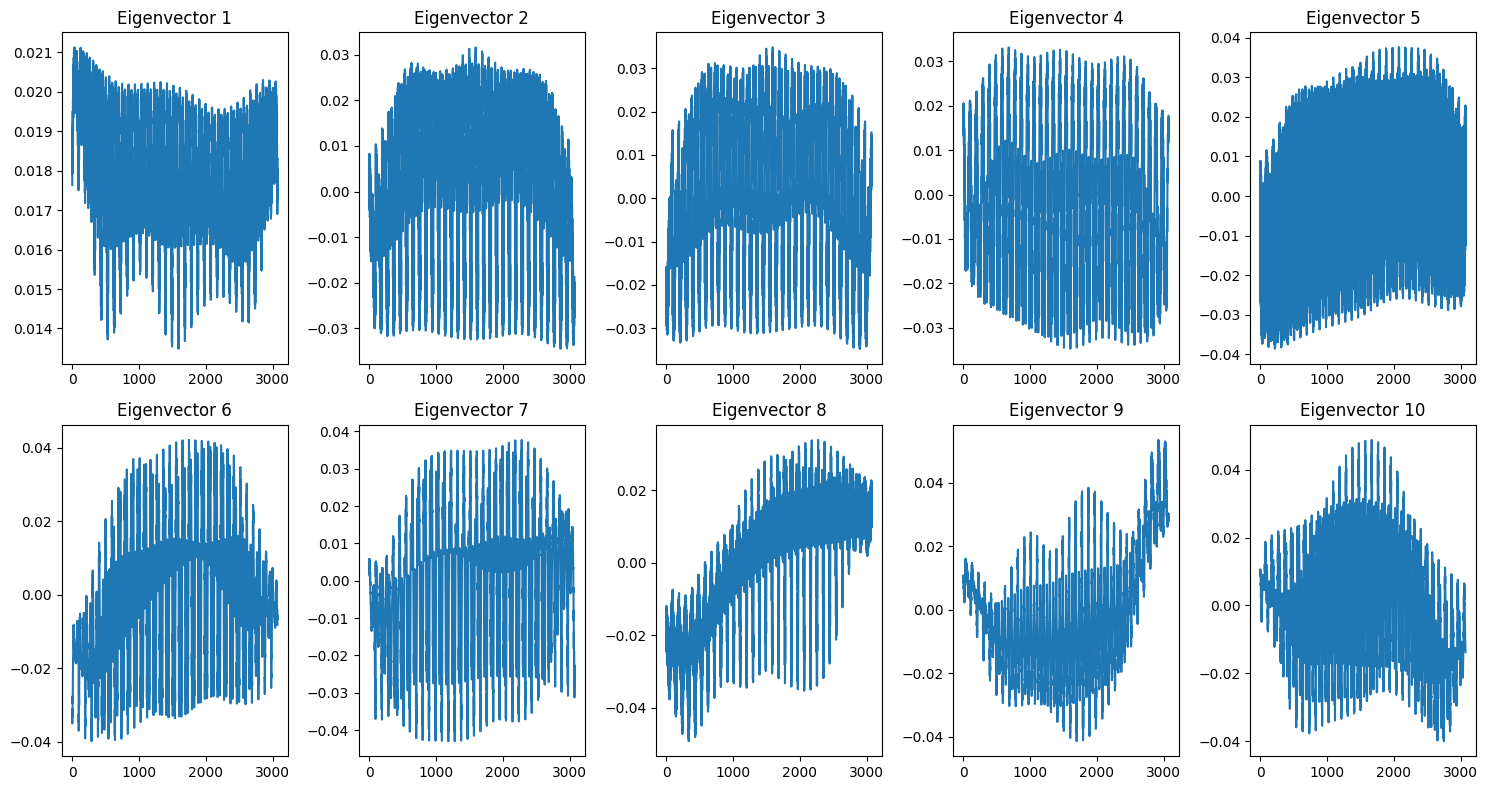

In [14]:
# Assuming top_10_eigenvectors is a 2D array where each row is an eigenvector
top_10_eigenvectors = pca.components_[:10, :]

# Plotting the values along each dimension for the top 10 eigenvectors
plt.figure(figsize=(15, 8))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.plot(top_10_eigenvectors[i])
    plt.title(f'Eigenvector {i + 1}')

plt.tight_layout()
plt.show()

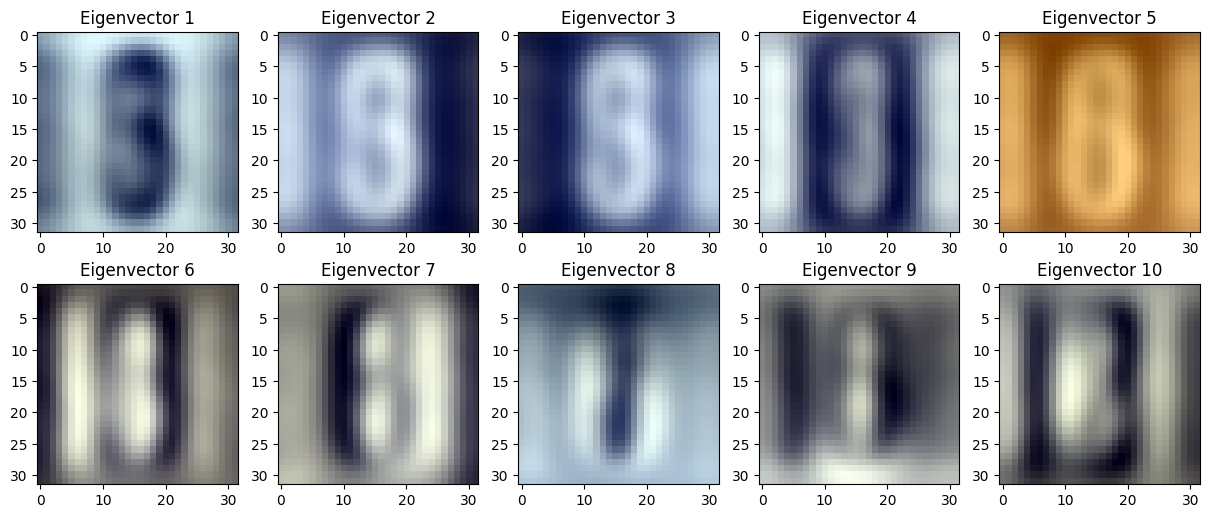

In [15]:


fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
    # Reshape eigenvector to image shape
    reshaped_eigenvector = top_10_eigenvectors[i].reshape((32, 32, 3))

    # Convert values to [0, 255] range
    normalized_eigenvector = ((reshaped_eigenvector - reshaped_eigenvector.min()) / 
                              (reshaped_eigenvector.max() - reshaped_eigenvector.min()) * 255)

    # Display the eigenvector as an image
    ax.imshow(normalized_eigenvector.astype(np.uint8), cmap='magma')

    ax.set_title(f'Eigenvector {i + 1}')

plt.show()


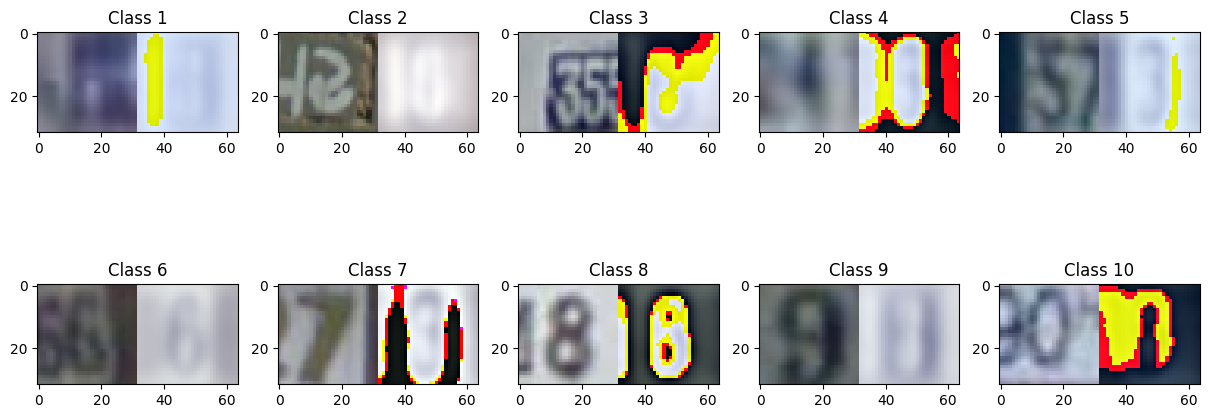

In [16]:
# Use the top 10 eigenvectors for reconstruction
top_10_eigenvectors = pca.components_[:10, :]

# Reconstruct 10 samples (one from each class) using the top 10 eigenvectors
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
    # Select one sample from each class
    class_indices = np.where(subset_classes_Y_train == i + 1)[0]
    sample_index = np.random.choice(class_indices, size=1)[0]
    
    # Get the original image
    original_image = subset_classes_X_train[:, :, :, sample_index]
    
    # Flatten the original image for reconstruction
    original_flattened = original_image.reshape((32*32*3, -1)).T
    
    # Project the flattened image onto the top 10 eigenvectors
    projected_image = np.dot(original_flattened, top_10_eigenvectors.T)
    
    # Reconstruct the image using the top 10 eigenvectors
    reconstructed_image = np.dot(projected_image, top_10_eigenvectors) + pca.mean_
    
    # Reshape the reconstructed image to its original shape
    reconstructed_image = reconstructed_image.reshape((32, 32, 3))
    
    # Display the original and reconstructed images side by side
    ax.imshow(np.hstack([original_image.astype(np.uint8), reconstructed_image.astype(np.uint8)]))
    ax.set_title(f"Class {i + 1}")

plt.show()


In [17]:
print("Shape of X_train_pca[:, :10]:", X_train_pca[:, :10].shape)
print("Shape of y_train:", y_train.shape)


Shape of X_train_pca[:, :10]: (25000, 10)
Shape of y_train: (73257, 1)


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Flatten the raw data for k-NN
X_train_raw_flattened = X_train.reshape((32*32*3, -1)).T

# Split the data into training and testing sets
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X_train_raw_flattened, y_train.flatten(), test_size=0.2, random_state=42)

# Define the values of k to try
k_values = [5, 7]

for k in k_values:
    # Run k-NN on raw data
    knn_raw = KNeighborsClassifier(n_neighbors=k)
    knn_raw.fit(X_train_raw, y_train_raw)
    y_pred_raw = knn_raw.predict(X_test_raw)
    accuracy_raw = accuracy_score(y_test_raw, y_pred_raw)

    print(f"Accuracy on raw data (k-NN, k={k}): {accuracy_raw:.4f}")

    # Project the raw data onto the top 'num_components_90' eigenvectors
    X_train_pca_projected = np.dot(X_train_raw_flattened, top_10_eigenvectors.T)

    # Split the PCA data into training and testing sets
    X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_train_pca_projected[:, :num_components_90], y_train.flatten(), test_size=0.2, random_state=42)

    # Run k-NN on PCA data
    knn_pca = KNeighborsClassifier(n_neighbors=k)
    knn_pca.fit(X_train_pca, y_train_pca)
    y_pred_pca = knn_pca.predict(X_test_pca)
    accuracy_pca = accuracy_score(y_test_pca, y_pred_pca)

    print(f"Accuracy after PCA (k-NN, k={k}): {accuracy_pca:.4f}")


Accuracy on raw data (k-NN, k=5): 0.4914
Accuracy after PCA (k-NN, k=5): 0.3086
Accuracy on raw data (k-NN, k=7): 0.4926
Accuracy after PCA (k-NN, k=7): 0.3118


In [19]:
# Top 27 eigenvectors for PCA
top_27_eigenvectors = pca.components_[:27, :]

# Project the raw data onto the top 27 eigenvectors
X_train_pca_projected_27 = np.dot(X_train_raw_flattened, top_27_eigenvectors.T)

# Split the PCA data into training and testing sets
X_train_pca_27, X_test_pca_27, y_train_pca_27, y_test_pca_27 = train_test_split(X_train_pca_projected_27, y_train.flatten(), test_size=0.2, random_state=42)

# Run k-NN on raw data for k=5
knn_raw_5 = KNeighborsClassifier(n_neighbors=5)
knn_raw_5.fit(X_train_raw, y_train_raw)
y_pred_raw_5 = knn_raw_5.predict(X_test_raw)
accuracy_raw_5 = accuracy_score(y_test_raw, y_pred_raw_5)

# Run k-NN on PCA data with dimension 27 for k=5
knn_pca_27_5 = KNeighborsClassifier(n_neighbors=5)
knn_pca_27_5.fit(X_train_pca_27, y_train_pca_27)
y_pred_pca_27_5 = knn_pca_27_5.predict(X_test_pca_27)
accuracy_pca_27_5 = accuracy_score(y_test_pca_27, y_pred_pca_27_5)

# Run k-NN on raw data for k=7
knn_raw_7 = KNeighborsClassifier(n_neighbors=7)
knn_raw_7.fit(X_train_raw, y_train_raw)
y_pred_raw_7 = knn_raw_7.predict(X_test_raw)
accuracy_raw_7 = accuracy_score(y_test_raw, y_pred_raw_7)

# Run k-NN on PCA data with dimension 27 for k=7
knn_pca_27_7 = KNeighborsClassifier(n_neighbors=7)
knn_pca_27_7.fit(X_train_pca_27, y_train_pca_27)
y_pred_pca_27_7 = knn_pca_27_7.predict(X_test_pca_27)
accuracy_pca_27_7 = accuracy_score(y_test_pca_27, y_pred_pca_27_7)

# Print accuracies
print(f"Accuracy on raw data (k-NN, k=5): {accuracy_raw_5:.4f}")
print(f"Accuracy after PCA (k-NN, k=5, 27 components): {accuracy_pca_27_5:.4f}")
print(f"Accuracy on raw data (k-NN, k=7): {accuracy_raw_7:.4f}")
print(f"Accuracy after PCA (k-NN, k=7, 27 components): {accuracy_pca_27_7:.4f}")


Accuracy on raw data (k-NN, k=5): 0.4914
Accuracy after PCA (k-NN, k=5, 27 components): 0.4872
Accuracy on raw data (k-NN, k=7): 0.4926
Accuracy after PCA (k-NN, k=7, 27 components): 0.4925


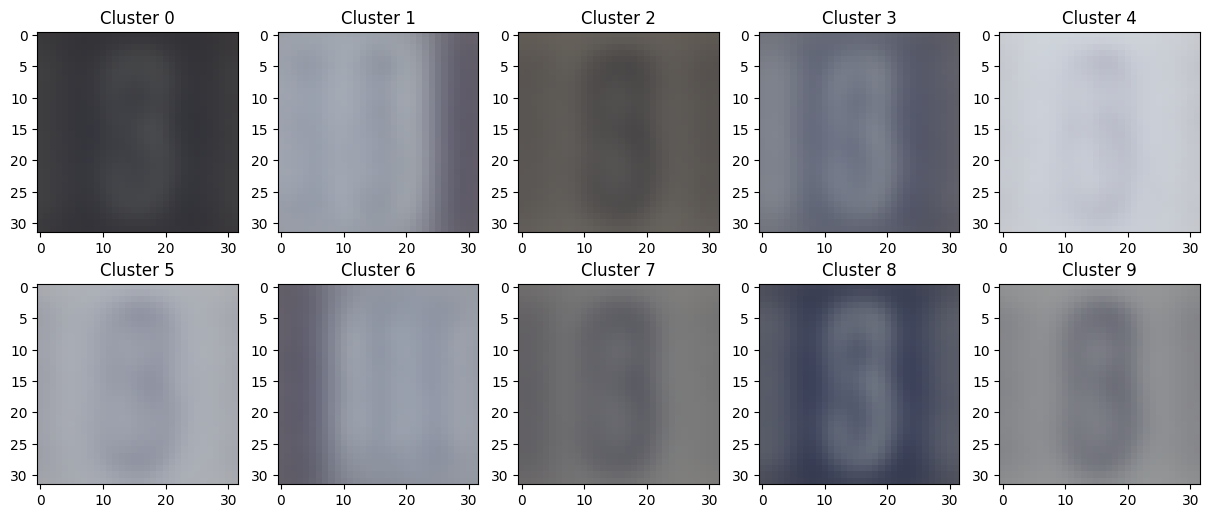

In [23]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

# Flatten the raw data for k-means clustering
X_train_raw_flattened = X_train.reshape((32*32*3, -1)).T

# Perform k-means clustering on raw data
kmeans_raw = KMeans(n_clusters=10,n_init=10, random_state=42)
kmeans_raw.fit(X_train_standardized)

# Get cluster labels and centroids
labels_raw = kmeans_raw.labels_
centroids_raw = kmeans_raw.cluster_centers_




[22584 15712  3353 22552  4356  1403  1747 11948 21702 21496]
(10,)


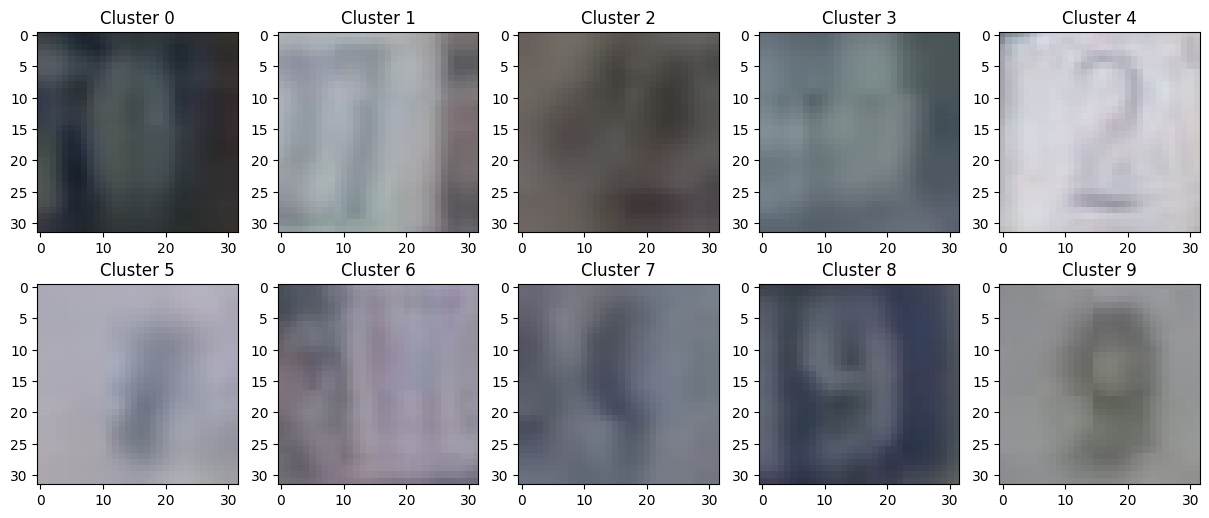

In [45]:
from sklearn.metrics.pairwise import pairwise_distances_argmin_min
closest_image_idx, _  = pairwise_distances_argmin_min(centroids_raw, X_train_standardized)
# print(closest_image_idx)
print(closest_image_idx.shape)
# Visualize the centroids
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
    nearest_image = X_train_standardized[closest_image_idx[i]].reshape((32, 32, 3))  # Fix the index
    ax.imshow(nearest_image.astype(np.uint8))
    ax.set_title(f"Cluster {i}")

plt.show()

In [34]:
# Project the raw data onto the top 10 eigenvectors
X_train_pca_projected_10 = X_train_pca[:,:10]

# Perform k-means clustering on PCA data with dimension 10
kmeans_pca_10 = KMeans(n_clusters=10,n_init=10, random_state=42)
kmeans_pca_10.fit(X_train_pca_projected_10)

# Get cluster labels and centroids
labels_pca_10 = kmeans_pca_10.labels_
centroids_pca_10 = kmeans_pca_10.cluster_centers_

# # Visualize the centroids
# fig, axes = plt.subplots(2, 5, figsize=(15, 6))
# for i, ax in enumerate(axes.flat):
#     centroid_image_pca_10 = np.dot(centroids_pca_10[i, :], top_10_eigenvectors) + pca.mean_
#     centroid_image_pca_10 = centroid_image_pca_10.reshape((32, 32, 3))
#     ax.imshow(centroid_image_pca_10.astype(np.uint8))
#     ax.set_title(f"Cluster {i}")

# plt.show()


(25000, 3072)
[41100 49318 37954  1469 31174 50452 58368 22084 37336 31512]
(10,)


IndexError: index 41100 is out of bounds for axis 0 with size 25000

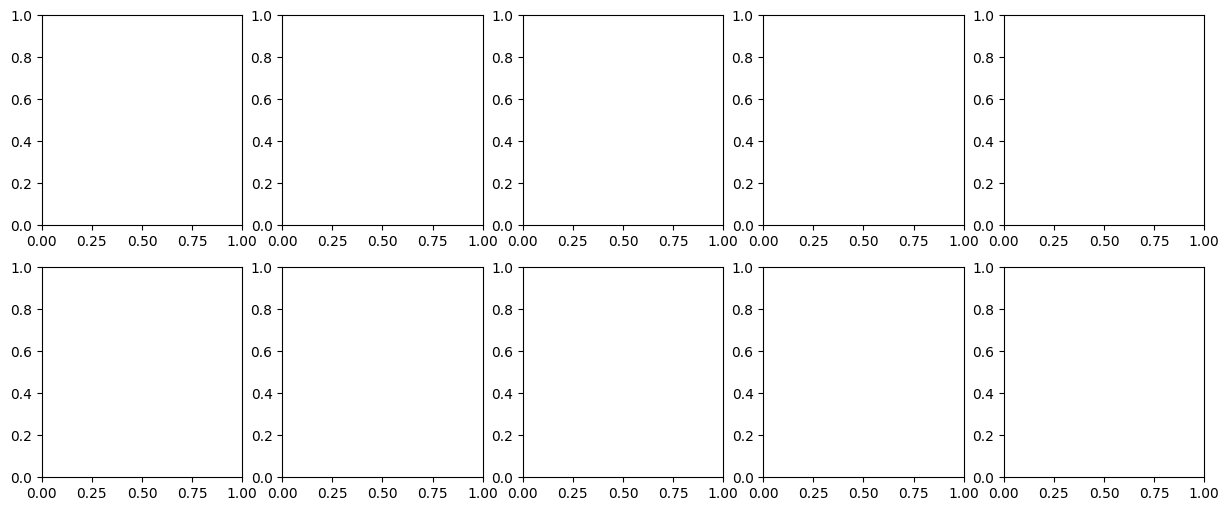

In [48]:
print(X_train_standardized.shape)
closest_image_idx_10, _  = pairwise_distances_argmin_min(centroids_pca_10,X_train_pca_projected_10)
print(closest_image_idx_10)
print(closest_image_idx_10.shape)
# Visualize the centroids
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
j=0
for i, ax in enumerate(axes.flat):
    nearest_image = X_train_standardized[closest_image_idx_10[j]].reshape((32, 32, 3))  # Fix the index
    ax.imshow(nearest_image.astype(np.uint8))
    ax.set_title(f"Cluster {i}")
    j=j+1
    if j==10:
        break

plt.show()